<h3>Imports</h3>

In [61]:
from PIL import Image
from collections import Counter
import datetime, os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import torchvision.transforms as transforms
import datetime
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
from copy import deepcopy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DataLoader = torch.utils.data.DataLoader

SEED = 1
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

<h3>Set-up classes and mappings</h3>

In [62]:
classes = ["ACK", "BCC", "MEL", "NEV", "SCC", "SEK"]
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
idx_to_class = {idx: cls_name for cls_name, idx in class_to_idx.items()}

<h3>Pre-processing: cropping and lowering resolution, per paper.</h3>

In [63]:
def crop_center(img, crop_ratio):
    width, height = img.size
    new_size = int(crop_ratio * min(width, height))
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = left + new_size
    bottom = top + new_size
    return img.crop((left, top, right, bottom))


transform = transforms.Compose([
    transforms.Lambda(lambda img: crop_center(img, 0.8)),
    transforms.Resize((224, 224)), # 224x224 is a common choice for RESNET-18, I'm told..  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(.5),
    transforms.RandomVerticalFlip(.2), # .2 is used in the Pacheco code 
])

combined_transform = transforms.Compose([
    transform,
    transform_flip
])

<h3>Dataset Class</h3>

In [64]:
class PAD_UFES_Dataset(Dataset):
    def __init__(self, img_dir, label_dict, transform=None):
        self.img_dir = img_dir
        self.label_dict = label_dict
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) 
                            if f.endswith('.png') and f in label_dict]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_name = self.label_dict[img_name]
        label = class_to_idx[label_name]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

<h3>Establish Paths</h3>

In [65]:
# data_path = os.path.expanduser('~/Desktop/230PRJ/PAD-UFES-20/')
data_path = os.path.expanduser('~/Desktop/CS230/Project/PAD-UFES-20/')
metadata_path = os.path.join(data_path, 'metadata.csv')
images_path = os.path.join(data_path, 'images')

<h3>Load Labels, Initialize and Split dataset</h3>

In [81]:
metadata = pd.read_csv(metadata_path)

label_dict = dict(zip(metadata['img_id'], metadata['diagnostic']))
label_dict = {f"{key}": value for key, value in label_dict.items()}

dataset = PAD_UFES_Dataset(img_dir=images_path, label_dict=label_dict, transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset_orig, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Duplicate the train dataset and apply the flip transformation.
# 50% and 20% of the images should be flipped horizontally and vertically, respectively.
# We don't want the flips to be applied to the validation and test datasets.
copied_dataset = deepcopy(train_dataset_orig)
train_dataset = ConcatDataset([train_dataset_orig, copied_dataset])
train_dataset.transform = combined_transform
train_size = len(train_dataset)

# Sanity check
assert train_size + test_size + val_size == 2298 + int(2298 * 0.8)

<h3>Get class weights for later: potentially weighted softmax, or re-sampling, etc.</h3>

In [82]:
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)
total_samples = sum(label_counts.values())
class_weights = [total_samples / label_counts[i] for i in range(len(classes))]
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

<h3>Set-up Data Loaders</h3>

In [83]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<h3>Display some images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].


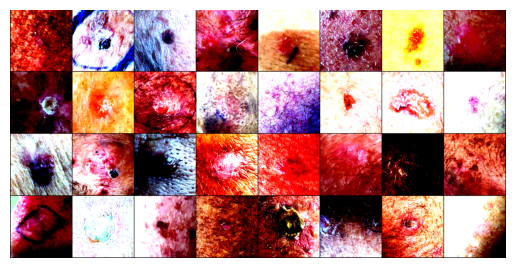

In [84]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, _ = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

<h1>Models</h1>

<h3>RESNET-18</h3>

In [85]:
assert len(classes) == 6

model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, len(classes))

# Unfreeze just the last CONV layer and last FC layer, and tweak it for 6 outputs
for param in model_resnet18.parameters():
    param.requires_grad = False
for param in model_resnet18.layer4.parameters():
    param.requires_grad = True
for param in model_resnet18.fc.parameters():
    param.requires_grad = True

model_resnet18 = model_resnet18.to(DEVICE)

/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
criterion_resnet18 = nn.CrossEntropyLoss(weight=class_weights) # Weighted CEL
optimizer_resnet18 = optim.SGD(model_resnet18.parameters(), lr=0.01, momentum=0.9) # Keeping this the same as the paper.
scheduler_resnet18 = optim.lr_scheduler.StepLR(optimizer_resnet18, step_size=7, gamma=0.1) # LR decay.

<h3>RESNET-50</h3>

In [87]:
assert len(classes) == 6

model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, len(classes))

# Unfreeze just the last CONV layer and last FC layer, and tweak it for 6 outputs
for param in model_resnet50.parameters():
    param.requires_grad = False
for param in model_resnet50.layer4.parameters():
    param.requires_grad = True
for param in model_resnet50.fc.parameters():
    param.requires_grad = True

model_resnet50 = model_resnet50.to(DEVICE)

/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
criterion_resnet50 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet50 = optim.SGD(model_resnet50.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler_resnet50 = optim.lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)

<h3>EfficientNet B4</h3>

In [89]:
assert len(classes) == 6

model_efficientnet_b4 = models.efficientnet_b4(pretrained=True)

for param in model_efficientnet_b4.parameters():
    param.requires_grad = False
for param in model_efficientnet_b4.features[-1].parameters():
    param.requires_grad = True
for param in model_efficientnet_b4.classifier.parameters():
    param.requires_grad = True

model_efficientnet_b4 = model_efficientnet_b4.to(DEVICE)

model_efficientnet_b4.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(model_efficientnet_b4.classifier[1].in_features, len(classes))
)

/opt/miniconda3/envs/230project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [90]:
criterion_efficientnet_b4 = nn.CrossEntropyLoss(weight=class_weights)
optimizer_efficientnet_b4 = optim.SGD(model_efficientnet_b4.parameters(), lr=0.01, momentum=0.9)
scheduler_efficientnet_b4 = optim.lr_scheduler.StepLR(optimizer_efficientnet_b4, step_size=7, gamma=0.1)

<h3>Custom (Simple) CNN Model</h3>

In [91]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # 3 CONV
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # 1 MAXPOOL
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2 FC
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, len(classes))
        # 1 DO
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # OP Dims: [batch_size, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # OP Dims: [batch_size, 64, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))  # OP Dims: [batch_size, 128, 28, 28]
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [92]:
simpleCNN = SimpleCNN(num_classes=len(classes))
assert len(classes) == 6, "incorrect number of classes"
simpleCNN = simpleCNN.to(DEVICE)

criterion_simpleCNN = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer_simpleCNN = optim.Adam(simpleCNN.parameters(), lr=0.001)

<h3>Helper Functions</h3>

In [93]:
def train(log_name, model, train_loader, optimizer, criterion, scheduler, num_epochs):
    writer = SummaryWriter('runs/' + log_name + '_' + str(datetime.datetime.now()).replace(" ", "_"))
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if scheduler is not None:
            scheduler.step()
        
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(DEVICE)
                val_labels = val_labels.to(DEVICE)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        val_loss = val_running_loss / val_size
        val_acc = val_running_corrects.double() / val_size
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        writer.add_scalar('Loss/train', epoch_loss, epoch+1)
        writer.add_scalar('Loss/validation', val_loss, epoch+1)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch+1)
        writer.add_scalar('Accuracy/validation', val_acc, epoch+1)

    writer.close()

In [94]:
def test(log_name, model, test_loader):
    writer = SummaryWriter('runs/' + 'test/' + log_name + '_' + str(datetime.datetime.now()).replace(" ", "_"))
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(DEVICE)
            test_labels = test_labels.to(DEVICE)
            
            test_outputs = model(test_inputs)
            _, test_preds = torch.max(test_outputs, 1)
            all_preds.append(test_preds)
            all_labels.append(test_labels)
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    num_classes = len(classes)
    accuracy_metric = MulticlassAccuracy(num_classes=num_classes, average='macro')
    precision_metric = MulticlassPrecision(num_classes=num_classes, average='macro')
    recall_metric = MulticlassRecall(num_classes=num_classes, average='macro')
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro')
    confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=num_classes)

    accuracy = accuracy_metric(all_preds, all_labels)
    precision = precision_metric(all_preds, all_labels)
    recall = recall_metric(all_preds, all_labels)
    f1_score = f1_metric(all_preds, all_labels)
    confusion_matrix = confusion_matrix_metric(all_preds, all_labels)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    writer.add_scalar('Accuracy/test', accuracy)
    writer.add_scalar('Precision/test', precision)
    writer.add_scalar('Recall/test', recall)
    writer.add_scalar('F1_score/test', f1_score)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    writer.add_figure('Confusion Matrix', plt.gcf(), global_step=0)
    
    writer.close()

<h3>Training Time</h3>

In [34]:
train("ResNet18", model_resnet18, train_loader, optimizer_resnet18, criterion_resnet18, scheduler_resnet18, num_epochs=20)

Epoch 1/20
Train Loss: 1.8958 Acc: 0.3700
Val Loss: 1.8529 Acc: 0.5066
Epoch 2/20
Train Loss: 1.2076 Acc: 0.5571
Val Loss: 0.9728 Acc: 0.5546
Epoch 3/20
Train Loss: 0.8895 Acc: 0.6540
Val Loss: 1.0382 Acc: 0.6070
Epoch 4/20
Train Loss: 0.8256 Acc: 0.6654
Val Loss: 1.0381 Acc: 0.5721
Epoch 5/20
Train Loss: 0.5674 Acc: 0.7514
Val Loss: 0.9793 Acc: 0.7293
Epoch 6/20
Train Loss: 0.4974 Acc: 0.7911
Val Loss: 0.9915 Acc: 0.6288
Epoch 7/20
Train Loss: 0.3927 Acc: 0.8210
Val Loss: 1.2041 Acc: 0.7511
Epoch 8/20
Train Loss: 0.2444 Acc: 0.9010
Val Loss: 0.8437 Acc: 0.7249
Epoch 9/20
Train Loss: 0.1774 Acc: 0.9195
Val Loss: 0.9099 Acc: 0.7511
Epoch 10/20
Train Loss: 0.1618 Acc: 0.9298
Val Loss: 0.8027 Acc: 0.7511
Epoch 11/20
Train Loss: 0.1255 Acc: 0.9478
Val Loss: 0.7838 Acc: 0.7467
Epoch 12/20
Train Loss: 0.1299 Acc: 0.9429
Val Loss: 0.9112 Acc: 0.7555
Epoch 13/20
Train Loss: 0.1204 Acc: 0.9385
Val Loss: 0.8166 Acc: 0.7424
Epoch 14/20
Train Loss: 0.1387 Acc: 0.9396
Val Loss: 1.0015 Acc: 0.7249
E

In [58]:
train("ResNet50", model_resnet50, train_loader, optimizer_resnet50, criterion_resnet50, scheduler_resnet50, num_epochs=15)

Epoch 1/15
Train Loss: 1.4205 Acc: 0.4842
Val Loss: 1.4143 Acc: 0.4858
Epoch 2/15
Train Loss: 0.9363 Acc: 0.6216
Val Loss: 0.8492 Acc: 0.6950
Epoch 3/15
Train Loss: 0.6571 Acc: 0.7114
Val Loss: 0.9046 Acc: 0.5861
Epoch 4/15
Train Loss: 0.5000 Acc: 0.7813
Val Loss: 0.7677 Acc: 0.7800
Epoch 5/15
Train Loss: 0.4412 Acc: 0.8188
Val Loss: 0.6660 Acc: 0.7887


KeyboardInterrupt: 

In [36]:
train("EfficientNetB4", model_efficientnet_b4, train_loader, optimizer_efficientnet_b4, criterion_efficientnet_b4, scheduler_efficientnet_b4, num_epochs=20)

Epoch 1/20
Train Loss: 1.6885 Acc: 0.3792
Val Loss: 1.5408 Acc: 0.3930
Epoch 2/20
Train Loss: 1.4642 Acc: 0.4499
Val Loss: 1.4186 Acc: 0.5153
Epoch 3/20
Train Loss: 1.3543 Acc: 0.5065
Val Loss: 1.3245 Acc: 0.5459
Epoch 4/20
Train Loss: 1.2758 Acc: 0.5277
Val Loss: 1.2526 Acc: 0.5328
Epoch 5/20
Train Loss: 1.2158 Acc: 0.5348
Val Loss: 1.2686 Acc: 0.5109
Epoch 6/20
Train Loss: 1.1846 Acc: 0.5256
Val Loss: 1.1881 Acc: 0.6114
Epoch 7/20
Train Loss: 1.1371 Acc: 0.5550
Val Loss: 1.1875 Acc: 0.5852
Epoch 8/20
Train Loss: 1.1429 Acc: 0.5593
Val Loss: 1.1512 Acc: 0.6201
Epoch 9/20
Train Loss: 1.1187 Acc: 0.5707
Val Loss: 1.1645 Acc: 0.5502
Epoch 10/20
Train Loss: 1.1150 Acc: 0.5609
Val Loss: 1.2101 Acc: 0.5939
Epoch 11/20
Train Loss: 1.0906 Acc: 0.5686
Val Loss: 1.2041 Acc: 0.6026
Epoch 12/20
Train Loss: 1.0959 Acc: 0.5615
Val Loss: 1.2430 Acc: 0.5721
Epoch 13/20
Train Loss: 1.1208 Acc: 0.5544
Val Loss: 1.1942 Acc: 0.5502
Epoch 14/20
Train Loss: 1.1103 Acc: 0.5577
Val Loss: 1.1371 Acc: 0.5502
E

In [24]:
train("simpleCNN", simpleCNN, train_loader, optimizer_simpleCNN, criterion_simpleCNN, None, num_epochs=1)

Epoch 1/1
Train Loss: 1.6718 Acc: 0.2837
Val Loss: 1.4732 Acc: 0.5033


<h3>Testing</h3>

In [38]:
test("ResNet18", model_resnet18, test_loader)

Test Accuracy: 0.6710


In [ ]:
test("ResNet50", model_resnet50, test_loader)

In [40]:
test("EfficientNetB4", model_efficientnet_b4, test_loader)

Test Accuracy: 0.5628


Accuracy: 0.3517
Precision: 0.4109
Recall: 0.3517
F1 Score: 0.3414


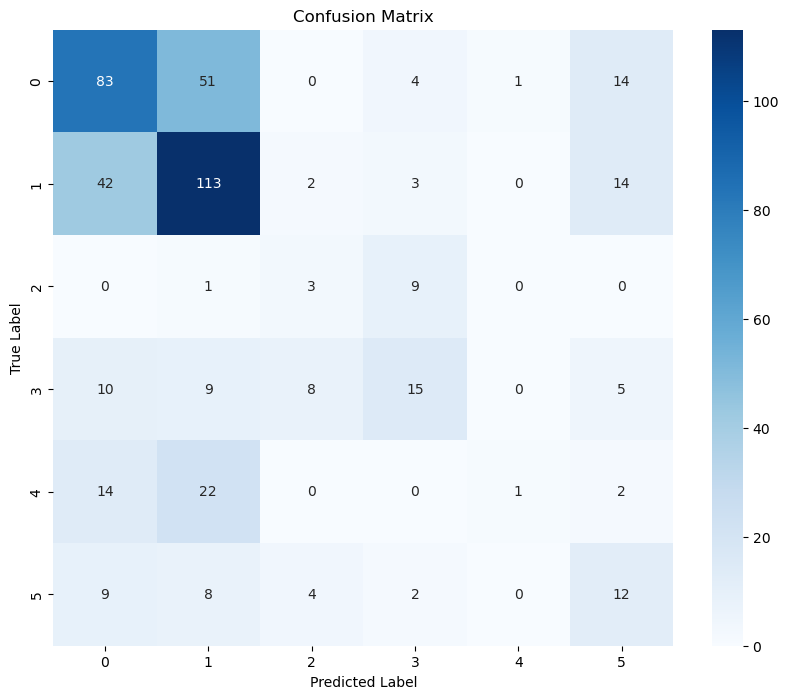

In [25]:
test("simpleCNN", simpleCNN, test_loader)

<h3>Results</h3>

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./runs